# Understanding Rock Samples

This notebook aims to demonstrate the structure of my data and the process of extracting 'subsamples' for training our model. \
Specifically, it focuses on rock samples obtained from a CT scan. To simplify the analysis, we will employ a binary representation that denotes two distinct media: pore space and rock.

In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from IPython.display import Image
import torch

from utils import *



import pyvista as pv
pv.start_xvfb()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How samples are acquired?

Let us look at the big picture to understand the rock samples

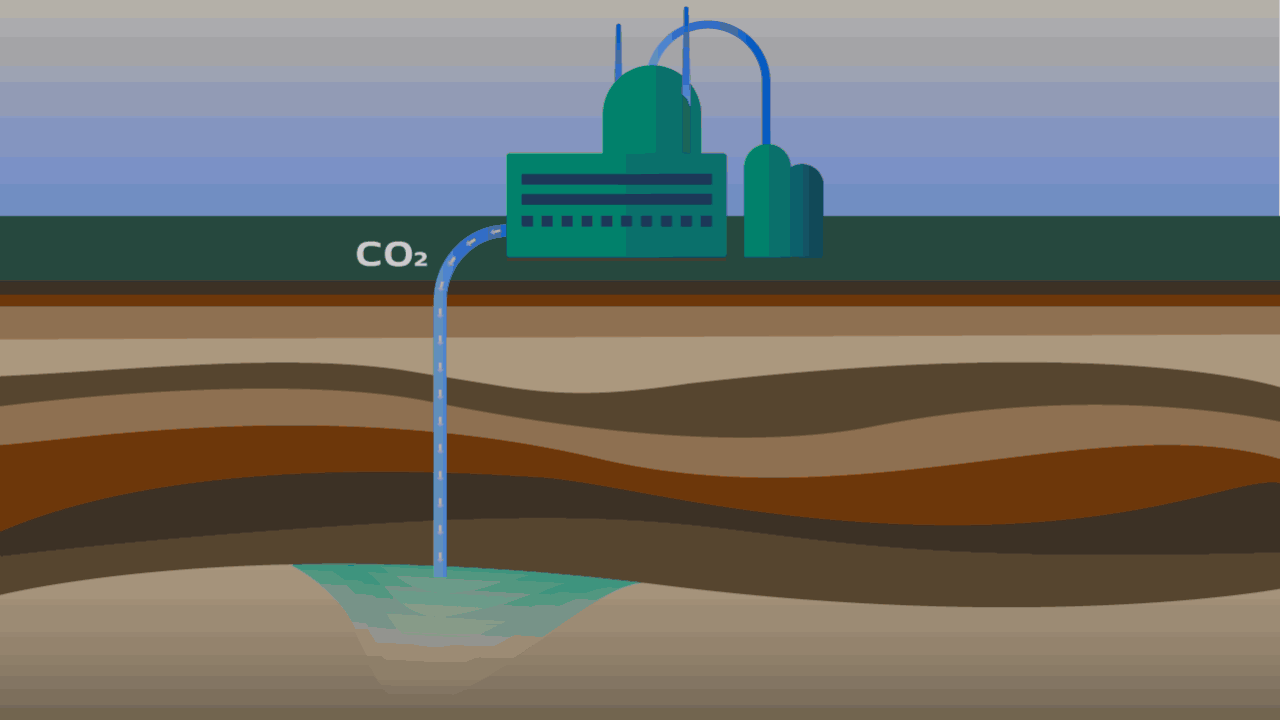

In [37]:
Image(filename='../assets/big_picture_samples.gif',width=1200, height=600)

In [38]:
dataset = tiff.imread('../old_files/data/berea/original/raw/berea.tif')

In [7]:
p = pv.Plotter()
grid = pv.UniformGrid(dims=(401,401,401))
grid.cell_data["values"] = dataset.flatten() 
clipped = grid.clip_box(factor=0.5)
p.add_mesh(clipped, cmap='gray', show_scalar_bar=False)
#         p.camera_position = [-5, 5, 5]
p.window_size = [1000,1000]

As depicted, we possess a single 3D sample, aiming to generate corresponding samples belonging to the same media. For this particular instance, we will generate 2D representations exclusively. To construct our dataset, we will extract non-overlapping windows of reduced dimensions (generative models necessitate abundant training samples).

## Subsamples

In [39]:
height, width = 128,128

window_size = (height, width)  # Specify the desired window size
tensor_3d = torch.from_numpy(dataset)  # Convert the 3D array to a PyTorch tensor
tensor_4d = tensor_3d.unsqueeze(0).unsqueeze(0)  # Add dimensions for batch and channels
windows = tensor_4d.unfold(2, window_size[0], window_size[0]).unfold(3, window_size[1], window_size[1])
windows = windows.reshape(-1, 1, window_size[0], window_size[1])/255  # Reshape the windows tensor


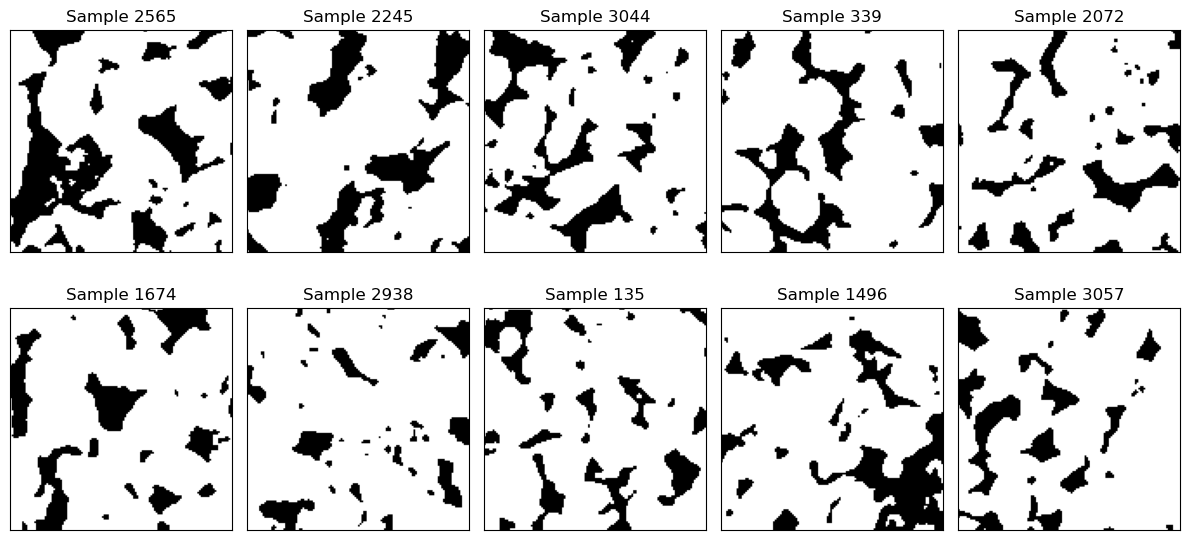

In [40]:
fig = plot_random_samples(windows, num_plots=10)  # Plot 10 random samples

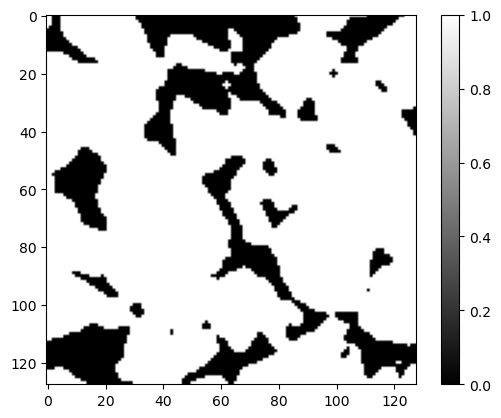

In [41]:
plt.imshow(windows[0,0,:,:], cmap='gray')
plt.colorbar()

## Training

# Training GAN for 2D generation of Beadpack dataset

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils   import spectral_norm 



import torch.optim as optim

from tqdm import tqdm

In [44]:
def seed_everything(seed=42):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

In [45]:
def save_checkpoint(model, optimizer, path="my_checkpoint.pth.tar"):
    """
    Saving training checkpoints
    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        WGAN model
    optimizer : :obj:`torch.optim`
        Optimizer
    path : :obj:`str`
        Path and file name
    """
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

In [46]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    """
    Loading training checkpoints
    Parameters
    ----------
    checkpoint_file : :obj:`str`
        Path and file name
    model : :obj:`torch.nn.Module`
        WGAN model
    optimizer : :obj:`torch.optim`
        Optimizer
    lr : :obj:`float`
        Learning rate
    """
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    # optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Generator architecture

In [47]:
class Generator(torch.nn.Module):
    def __init__(self, in_channel=16, out_channel=128):
        
        super(Generator, self).__init__()
        # channel_in = 16
        # H = 16
        # W = 16
        self.conv_net = torch.nn.Sequential(
            # dim: Bx16x16x16
            torch.nn.ConvTranspose2d(in_channels=in_channel, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(32),
            torch.nn.GELU(),
            # dim: Bx32x32x32
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(64),
            torch.nn.GELU(),
            # dim: Bx64x64x64
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(128),
            torch.nn.GELU(),
            # dim: Bx128x128x128
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, z):
        # z dim: Bx16x16x16
        return self.conv_net(z)

## Discriminator architecture

In [48]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channel=128, out_channel=1):
        
        super(Discriminator, self).__init__()
        # channel_in = 128
        # H = 128
        # W = 128
        self.conv_net = torch.nn.Sequential(
            # dim: Bx128x128x128
            torch.nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(64),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx64x64x64
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(32),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx32x32x32
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(16),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx16x16x16
            torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(8),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx8x8x8
            torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(4),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx4x4x4
            torch.nn.Conv2d(in_channels=4, out_channels=2, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(2),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx1x1x1
            torch.nn.Conv2d(in_channels=2, out_channels=out_channel, kernel_size=4, stride=2, padding=1),
        )
        
    def forward(self, z):
        # z dim: Bx128x128x128
        return self.conv_net(z)

## Data Loader

In [49]:
class MyLoader(Dataset):
    """
    Prepare dataset for data loader
    Attributes:
    data: dataset
    """

    def __init__(self, data):
        super(MyLoader, self).__init__()
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, item):
        return self.data[item, ...].squeeze()


## Gradient penalty 

In [50]:
def gradient_penalty(critic, real, fake, device="cpu"):
    """
    Gradient penalty for WGAN-GP
    Parameters
    ----------
    critic : :obj:`torch.nn.Module`
        Critic model of WGAN
    real : :obj:`torch.Tensor`
        Tensor of real data of size BxCxWxH
    fake : :obj:`torch.Tensor`
        Tensor of fake data of size BxCxWxH
    device : :obj:`str`
        Device to run the computation cpu or cuda
    Returns
    -------
    : :obj:`torch.Tensor`
        Scalar value of gradient penalty
    """

    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)

    return torch.mean((gradient_norm - 1) ** 2)

## Porosity function for the extra term in the loss of the Discriminator

In [51]:
def porosity(phi):
    r"""
    Computes the porosity of a sample (image, real or generated).
    Here 0 values correspond to the voids, and 1 values correspond to the grains.
    
    Parameters
    ----------
    phi: input array corresponding to the pixels of the image.
    
    
    Returs
    ------
    porosity: float
              Returns the computed porosity, it is equal to the sum of voids (0), over
              the sum of the voids(0) and solids(1)
    """
    voids = torch.sum(torch.round(phi)  == 0, dim=(-2, -1))
    solids = torch.sum(torch.round(phi)  == 1, dim=(-2, -1))
    phi_computed = voids/(voids + solids)
    
    return phi_computed

## Uploading real dataset

In [53]:
# # Traditional 2D slices
# DATA = torch.load('./data/beadpack/original/tiff/dataset_beadpack.pt')/255
# DATASET = DATA.clone()[:, 0, :, :].unsqueeze(1)
# print(DATASET.shape)
DATASET = windows.clone()

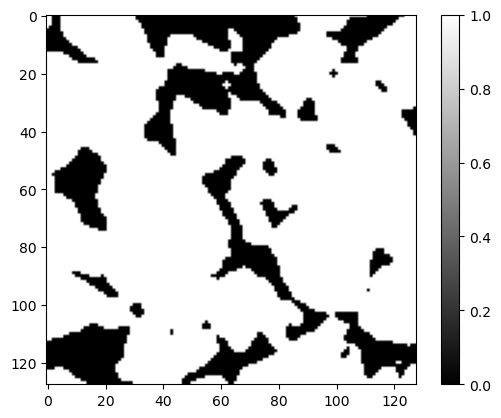

In [54]:
plt.imshow(DATASET[0,0,:,:], cmap='gray')
plt.colorbar()

## Hyper-parameters selection

In [61]:
# Device and Model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_GEN = ""
CHECKPOINT_CRITIC = ""

# Training hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 16

Z_DIM = 16

NUM_EPOCHS = 501
CRITIC_ITERATIONS = 4
LAMBDA_GP = 25

In [62]:
# initialize data loader
loader = DataLoader(
    MyLoader(DATASET),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## Starting Training

In [63]:
seed_everything(seed=11)

#Mean Porosity of the training
poro_real = torch.mean(porosity(DATASET)).reshape(1,1)

# initialize generator and critic
gen = Generator(in_channel=16, out_channel=128).to(DEVICE)
# initialize_weights(gen)

critic = Discriminator(in_channel=128, out_channel=128).to(DEVICE)
# initialize_weights(critic)

gen.train()
critic.train()

# initialize optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
scheduler_gen = optim.lr_scheduler.CosineAnnealingLR(opt_gen, 4 * NUM_EPOCHS)

opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
scheduler_critic = optim.lr_scheduler.CosineAnnealingLR(opt_critic, 4 * NUM_EPOCHS * CRITIC_ITERATIONS)

# fixed noise for display
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, Z_DIM, Z_DIM).to(DEVICE)

# Criterion for measuring porosity difference
criterion = torch.nn.MSELoss()

# Training
losses_gen = []
losses_critic = []

for epoch in range(NUM_EPOCHS):
    batches = tqdm(loader)
    mean_loss_gen = 0
    mean_loss_critic = 0
    for batch_idx, real in enumerate(batches):
        real = real.float().unsqueeze(1).to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, Z_DIM, Z_DIM).to(DEVICE)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            poro_fake = porosity(fake)
            poro_real_batch=poro_real.repeat(cur_batch_size,1).to(DEVICE)
            #poro_real = porosity(real)
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp + 
                    1 * criterion(poro_fake, poro_real_batch)
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            scheduler_critic.step()

            # mean critic loss
            mean_loss_critic += loss_critic.item()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        scheduler_gen.step()

        # mean generator loss
        mean_loss_gen += loss_gen.item()

        batches.set_postfix(
            epoch=epoch,
            gen_loss=loss_gen.item(),
            critic_loss=loss_critic.item(),
        )
    if epoch%50==0:
        plt.figure()
        plt.imshow(gen(fixed_noise)[0,0].detach().cpu().numpy(), cmap='gray')

        plt.figure(figsize=(10, 10))
        plt.plot(losses_gen, label='generator', linewidth=2)
        plt.plot(losses_critic, label='critic', linewidth=2)
        plt.legend(loc=0)
        plt.show()

    # save losses at each epoch
    losses_gen.append(mean_loss_gen / batch_idx)
    losses_critic.append(mean_loss_critic / (batch_idx * CRITIC_ITERATIONS))
    



  0%|          | 0/225 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.76 GiB total capacity; 5.01 GiB already allocated; 111.81 MiB free; 5.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

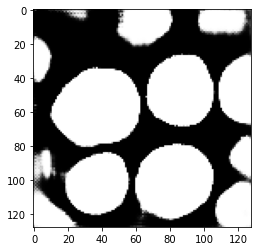

In [ ]:
plt.figure()
plt.imshow(gen(fixed_noise)[0,0].detach().cpu().numpy(), cmap='gray')

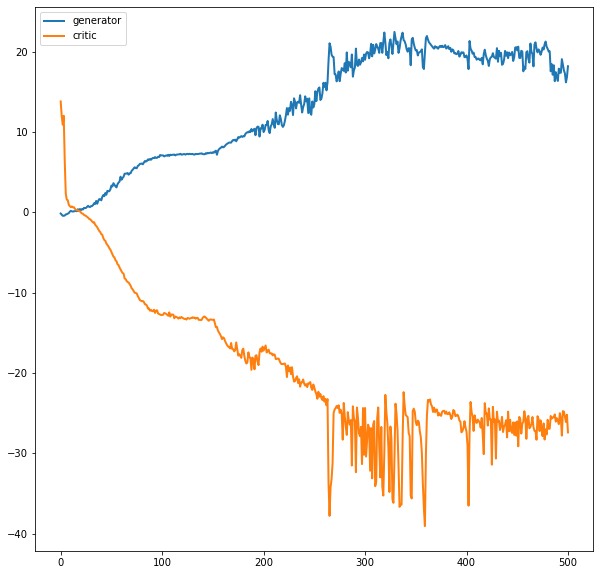

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(losses_gen, label='generator', linewidth=2)
plt.plot(losses_critic, label='critic', linewidth=2)
plt.legend(loc=0)
plt.show()